In [96]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches
from IPython.display import display



In [97]:
USE_GPU = True
TRAIN = False

In [98]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724662582.973785    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724662582.976345    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724662582.978500    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724662582.981502    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [99]:
IMAGE_SIZE = 24
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.001
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [100]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 22, 24), (2740,), (2740, 24, 24, 1))

In [101]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(24, 24, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 12, 12, 24)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 6, 6, 48)       │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 3, 3, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 2, 2, 192)      │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 2, 2, 384)      │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 1, 1, 1)        │         1,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,057 (1.50 MB)

 Trainable params: 394,057 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=3, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=2, strides=1, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (None, 1, 1, 576)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 4, 4, 192)      │     1,769,472 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 4, 4, 192)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4, 4, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 4, 4, 96)       │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 8, 8, 48)       │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 24, 24, 24)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 24, 24, 24)     │         9,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │             

 Total params: 2,380,321 (9.08 MB)

 Trainable params: 2,379,649 (9.08 MB)

 Non-trainable params: 672 (2.62 KB)

In [103]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [104]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [105]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

In [106]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

(18, 24, 24, 1)


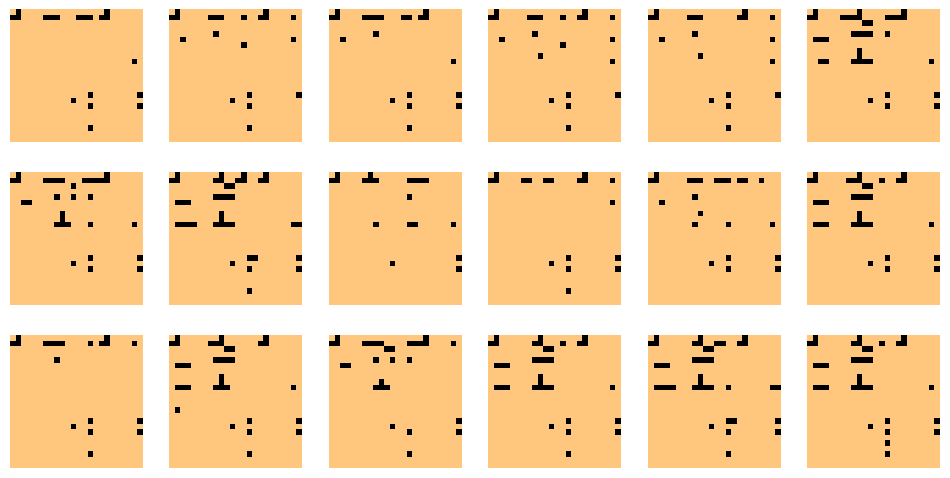

In [107]:
if TRAIN:
    
    noise = np.random.normal(size=(18, Z_DIM))
    generated_languages = generator.predict(noise)

    np.savez_compressed(
        "./data/generated_languages.npz",
        generated_languages=generated_languages,
    )

else:
    data = np.load("./data/generated_languages.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]

print(generated_languages.shape)

# normalise
generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
# sigmoid
generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

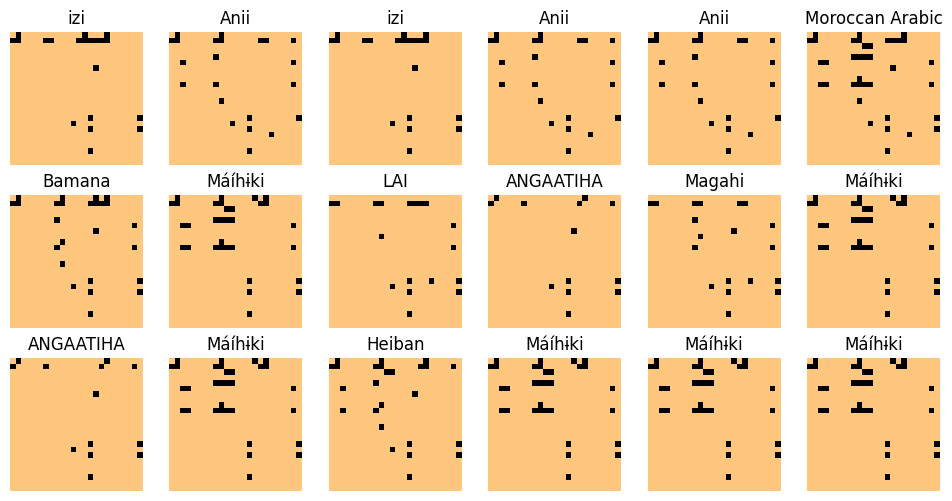

0.01765046296296296

In [108]:
# find closest matches

closest_idx, closest, closest_diff = get_closest_matches(X, generated_languages, n=18)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

np.mean(closest_diff)

In [109]:
# find exact matches

exact_idx = get_exact_matches(X, generated_languages)
exact = np.take(X, exact_idx)
exact_language_names = np.take(language_names_selected, exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

X.shape, exact_idx.shape

No exact matches. Noice!


((2740, 24, 24, 1), (0,))

In [110]:
# how different is each language from the mean?
mean_lang = np.mean(X, axis=0).reshape(-1)

diff_from_mean = np.apply_along_axis(lambda g: np.mean(np.abs(mean_lang - g)), -1, generated_languages.reshape(generated_languages.shape[0], -1))

most_different = np.argmax(diff_from_mean)
least_different = np.argmin(diff_from_mean)

most_different, least_different


(16, 4)

In [111]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_pl_tbl_df.shape, cons_npl_tbl_df.shape, cons_coart_tbl_df.shape, vowels_tbl_df.shape

((14, 24), (7, 10), (3, 4), (7, 10))

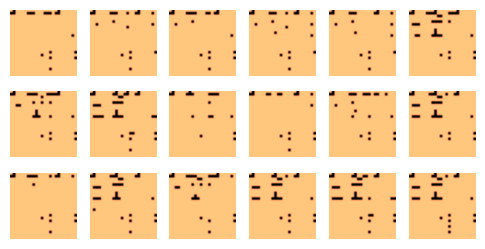

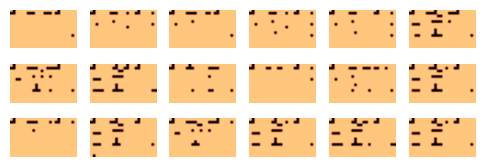

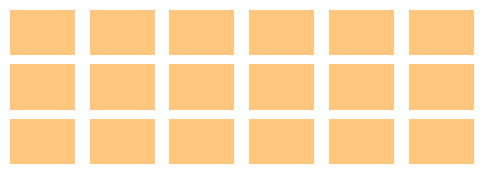

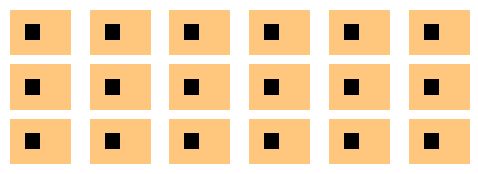

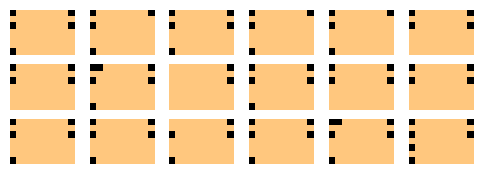

((18, 14, 24, 1), (18, 7, 10, 1), (18, 3, 4, 1), (18, 7, 10, 1))

In [112]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:10 :]
generated_cons_coart = generated_languages[:, 15:18, 10:14 :]
generated_vowels = generated_languages[:, 15:22, 14:24 :]

display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(6, 3))


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(6, 2))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(6, 2))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [113]:
def create_ipa_table(lang, tbl):
    phonemes = np.where(lang > 0, tbl.replace(np.nan, "*").replace("", "*"), np.full(lang.shape, "_")).astype(str)
    return pd.DataFrame(
        np.char.add(
            np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " ")),
            phonemes[:,1::2]
        ), 
        index=tbl.index, 
        columns=tbl.columns[0::2]
    )

for idx in [most_different, least_different]:

    sample_cons_pl_tbl = create_ipa_table(np.squeeze(generated_cons_pl[idx]), cons_pl_tbl_df)

    display(sample_cons_pl_tbl)

    sample_cons_npl_tbl = create_ipa_table(np.squeeze(generated_cons_npl[idx]), cons_npl_tbl_df)

    display(sample_cons_npl_tbl)

    sample_cons_coart_tbl = create_ipa_table(np.squeeze(generated_cons_coart[idx]), cons_coart_tbl_df)

    display(sample_cons_coart_tbl)

    sample_vowels_tbl = create_ipa_table(np.squeeze(generated_vowels[idx]), vowels_tbl_df)

    display(sample_vowels_tbl)

,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ m,_ _,_ _,_ _,_ n,_ _,_ _,_ _,_ ŋ,_ _,_ _,_ _
Plosive,p b,_ _,_ _,_ _,t d,_ _,ʈ ɖ,_ _,k ɡ,_ _,_ _,_ _
Sibilant affricate,_ _,_ _,_ _,_ _,_ _,t̠ʃ d̠ʒ,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Sibilant fricative,_ _,_ _,_ _,_ _,s z,ʃ ʒ,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant fricative,_ β,f v,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Approximant,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Tap/flap,_ _,_ _,_ _,_ _,_ ɾ,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Trill,_ _,_ _,_ _,_ _,_ r,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Fricative,_ β,f v,θ̼ _,_ _,s z,ʃ ʒ,_ _,ç _,_ _,_ _,_ _,h ɦ


,Bilabial,Dental,Palato-alveolar,Palatal,Uvular
Ejective Stop,_ _,_ _,_ _,_ _,_ _
Ejective Fricative,_ _,_ _,_ _,_ _,_ _
Ejective Affricate,_ _,_ _,_ _,_ _,_ _
Ejective Lateral,_ _,_ _,_ _,_ _,_ _
Click,_ _,_ _,_ _,_ _,_ _
Implosive Voiced,_ _,_ _,_ _,_ _,_ _
Implosive Voiceless,_ _,_ _,_ _,_ _,_ _


,Labial–palatal,Velarized alveolar
Fricative,_ _,_ _
Approximant,_ w,_ _
Lateral approximant,_ _,_ _


,Front unrounded,Near-front unrounded,Central unrounded,Near-back unrounded,Back unrounded
Close,i y,_ _,_ _,_ _,_ u
Near-close,_ _,_ _,_ _,_ _,_ _
Close-mid,e _,_ _,_ _,_ _,_ o
Mid,_ _,_ _,_ _,_ _,_ _
Open-mid,_ _,_ _,_ _,_ _,_ _
Near-open,_ _,_ _,_ _,_ _,_ _
Open,a _,_ _,_ _,_ _,_ _


,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ m,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ ŋ,_ _,_ _,_ _
Plosive,p b,_ _,_ _,_ d̪,t d,_ _,_ _,_ _,k ɡ,_ _,_ _,ʔ _
Sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Sibilant fricative,_ _,_ _,_ _,_ _,s _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant fricative,_ _,f _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,h _
Approximant,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Tap/flap,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Trill,_ _,_ _,_ _,_ _,_ r,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Fricative,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,h _


,Bilabial,Dental,Palato-alveolar,Palatal,Uvular
Ejective Stop,_ _,_ _,_ _,_ _,_ _
Ejective Fricative,_ _,_ _,_ _,_ _,_ _
Ejective Affricate,_ _,_ _,_ _,_ _,_ _
Ejective Lateral,_ _,_ _,_ _,_ _,_ _
Click,_ _,_ _,_ _,_ _,_ _
Implosive Voiced,_ _,_ _,_ _,_ _,_ _
Implosive Voiceless,_ _,_ _,_ _,_ _,_ _


,Labial–palatal,Velarized alveolar
Fricative,_ _,_ _
Approximant,_ w,_ _
Lateral approximant,_ _,_ _


,Front unrounded,Near-front unrounded,Central unrounded,Near-back unrounded,Back unrounded
Close,i _,_ _,_ _,_ _,_ u
Near-close,_ _,_ _,_ _,_ _,_ _
Close-mid,e _,_ _,_ _,_ _,_ _
Mid,_ _,_ _,_ _,_ _,_ _
Open-mid,_ _,_ _,_ _,_ _,_ _
Near-open,_ _,_ _,_ _,_ _,_ _
Open,a _,_ _,_ _,_ _,_ _
